In [2]:
# import packages 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
import os
import re
from scipy import stats

In [3]:
# Save progress 
HISTORY_FILEPATH = r"C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysis.py"
def SAVE_PROGRESS(dst_file_path):
    from datetime import datetime
    dst_dir_path, dst_file_name = os.path.split(dst_file_path)
    dst_file_name = os.path.splitext(dst_file_name)[0] + "_" + datetime.today().strftime('%Y-%m-%d') + os.path.splitext(dst_file_name)[1]
    dst_file_path = os.path.join(dst_dir_path, dst_file_name)
    if not os.path.isdir(dst_dir_path):
        os.makedirs(dst_dir_path)
    if os.path.exists(dst_file_path):
        os.remove(dst_file_path)
    %history -t -g -f $dst_file_path
    print("Progress saved to: " + dst_file_path)

In [4]:
#FUNCTION: list packages 
def listPkgNames(srcDir):
    import os
    assert(os.path.exists(srcDir))
    pkgNameSuffix = "_Pkg"
    subDirNameList = [iSubDirName for iSubDirName in os.listdir(srcDir) if os.path.isdir(srcDir + "\\" + iSubDirName)]
    pkgNameList = [iSubDirName for iSubDirName in subDirNameList if iSubDirName[-len(pkgNameSuffix):] == pkgNameSuffix]
    return pkgNameList

def sortPkgNames(src_pkgNameList):
    PkgNumStrPrefix = r"_F"
    pkgNumStrSuffix = "_Pkg"
    pkgNumRe = PkgNumStrPrefix + r"[0-9]+" + pkgNumStrSuffix
    src_pkgNames = np.array(src_pkgNameList)
    pkgNums = np.zeros(src_pkgNames.shape)
    for iPkg in range(len(src_pkgNames)):
        pkgName = src_pkgNames[iPkg]
        pkgNum = int(re.findall(pkgNumRe, pkgName)[0][len(PkgNumStrPrefix):-len(pkgNumStrSuffix)])
        pkgNums[iPkg] = pkgNum
    return src_pkgNames[np.argsort(pkgNums)]

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysis_2023-07-18.py


In [5]:
# count spike in time stamp
def cnt_spike_in_time_stamp(spike_event, stim_tstamp):
    
    nof_traces = spike_event.shape[0]
    trace_len = spike_event.shape[1]
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    spike_cnts = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
        
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_start = max(0, tstamp_start)
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            tstamp_end = min(trace_len, tstamp_end)
            if tstamp_start >= tstamp_end:
                continue
            tstamp_spike_event_mask = spike_event[:, tstamp_start:tstamp_end] > 0
            nof_spikes = np.sum(tstamp_spike_event_mask.astype(int), axis = -1)
            spike_cnts[i_orint, i_step, :] = nof_spikes
            
    return spike_cnts

def calculate_spike_rate_s(spike_cnts, stim_tstamp_s):
    nof_orint = spike_cnts.shape[0]
    nof_steps = spike_cnts.shape[1]
    nof_traces = spike_cnts.shape[2]
    
    spike_rate = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            stamp_t_s = stim_tstamp_s[i_orint, i_step, :]
            duration_s = stamp_t_s[-1] - stamp_t_s[0]
            if duration_s == 0:
                continue
            spike_rate[i_orint, i_step, :] = spike_cnts[i_orint, i_step, :].astype(np.float) / duration_s
            
    return spike_rate
    
SAVE_PROGRESS(HISTORY_FILEPATH)   

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysis_2023-07-18.py


In [6]:
# stats test function
def stim_step_t_test(spike_rate, test_steps = [1,0]):
    alternative = "greater"
    
    nof_orints = spike_rate.shape[0]
    test_results = []
    pvalues = np.zeros((nof_orints,))
    for i_orient in range(nof_orints):
        a = spike_rate[i_orient, test_steps[0], :]
        b = spike_rate[i_orient, test_steps[1], :] 
        result = stats.ttest_ind(a, b, alternative = alternative)
        test_results.append(result)
        pvalues[i_orient] = result.pvalue
    return pvalues, test_results

def stim_step_sum_t_test(spike_cnt, test_steps = [1,0]):
    alternative = "greater"
    a = np.sum(spike_cnt[:, test_steps[0], :], axis = 0)
    b = np.sum(spike_cnt[:, test_steps[1], :], axis = 0)
    result = stats.ttest_ind(a, b, alternative = alternative)
    return result
    
def stim_step_anova_oneway(spike_rate, test_step = 1):
    nof_orints = spike_rate.shape[0]
    comp_group = []
    for i_orint in range(nof_orints):
        comp_group.append(spike_rate[i_orint, test_step, :])
    result = stats.f_oneway(*comp_group)
    return result

def calculate_gOSI(responses, orientations):
    gOSI = np.abs(np.sum( responses * np.exp(2.0j * orientations) )) / np.sum(responses)
    return gOSI

def calculate_vec_sum_complex(responses, orientations):
    vec_sum_complex = np.sum(responses * np.exp(1.0j * orientations))
    return vec_sum_complex
    
SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysis_2023-07-18.py


In [7]:
# basic plot functions
def raster_plot(spike_events):
    plt_xs = np.arange(spike_events.shape[1])
    event_xs = []
    for i_trail in range(spike_events.shape[0]):
        event_xs.append(plt_xs[spike_events[i_trail,:] > 0])
    plt.eventplot(event_xs, color = "k",
                 lineoffsets = 1,
                 linelengths = 1,
                 linewidths = 0.5)

def stim_time_stamp_axvspan(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvspan(tstamp_start, tstamp_end, facecolor = facecolor_strs[i_step], alpha=0.1)
    
SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysis_2023-07-18.py


In [52]:
# analysis code
def stats_analysis(
    i_roi,
    spike_event,
    stim_tstamp,
    stim_tstamp_s,
    orient_angles_rad,
    t_test_alpha,
    anova_test_alpha,
    dst_dir_path,
    process_mode = "show",
):
    cur_spike_event = spike_event
    cur_spike_cnts = cnt_spike_in_time_stamp(cur_spike_event, stim_tstamp)
    cur_spike_rate = calculate_spike_rate_s(cur_spike_cnts, stim_tstamp_s)
    
    t_test_pvals, t_test_results = stim_step_t_test(cur_spike_rate, test_steps = [1,0])
    gather_t_test_result = stim_step_sum_t_test(cur_spike_cnts, test_steps = [1,0])
    anova_test_result = stim_step_anova_oneway(cur_spike_rate, test_step = 1)
    
    nof_traces = cur_spike_event.shape[0]
    nof_steps = stim_tstamp.shape[1]
    nof_orints = stim_tstamp.shape[0]

    t_test_effective_alpha = t_test_alpha/nof_orints
    
    t_test_pass = np.min(t_test_pvals) <= t_test_effective_alpha
    gather_t_test_pass = gather_t_test_result.pvalue <= t_test_alpha
    annova_test_pass = anova_test_result.pvalue < anova_test_alpha
    
    responses = np.mean(cur_spike_rate[:,1,:], axis = -1)
    vec_sum_complex = calculate_vec_sum_complex(responses, orient_angles_rad)
    gOSI = calculate_gOSI(responses, orient_angles_rad)
    
    plt_x_ticks = np.unique(stim_tstamp.flatten())
    plt_x_ticks_labels = np.unique(stim_tstamp_s.flatten())
    
    result_summary = dict()
    result_summary["i_roi"] = i_roi
    result_summary["stim_tstamp"] = stim_tstamp
    result_summary["stim_tstamp_s"] = stim_tstamp_s
    result_summary["cur_spike_event"] = cur_spike_event
    result_summary["cur_spike_cnts"] = cur_spike_cnts
    result_summary["cur_spike_rate"] = cur_spike_rate
    result_summary["t_test_pvals"] = t_test_pvals
    result_summary["t_test_results"] = t_test_results
    result_summary["gather_t_test_result"] = gather_t_test_result
    result_summary["anova_test_result"] = anova_test_result
    result_summary["t_test_effective_alpha"] = t_test_effective_alpha
    result_summary["t_test_alpha"] = t_test_alpha
    result_summary["anova_test_alpha"] = anova_test_alpha
    result_summary["t_test_pass"] = t_test_pass
    result_summary["gather_t_test_pass"] = gather_t_test_pass
    result_summary["annova_test_pass"] = annova_test_pass
    result_summary["responses"] = responses
    result_summary["vec_sum_complex"] = vec_sum_complex
    result_summary["gOSI"] = gOSI
    
    if process_mode == "show" or process_mode == "save":
        
        if process_mode == "write":
            mpl.rcParams['pdf.fonttype'] = 42
            mpl.rcParams['ps.fonttype'] = 42
            plt.ioff()
        if process_mode == "show":
            plt.ion()
        
        fig = plt.figure(figsize = (16,16), dpi = 200)

        plt.subplot(6,1,1)
        stim_time_stamp_axvspan(stim_tstamp)
        raster_plot(cur_spike_event)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("time(s)")
        plt.ylabel("trail")
        plt.title("raster plot")

        plt.subplot(6,1,2)
        for i_step in range(nof_steps):
            plt_bar_wdiths = stim_tstamp[:,i_step, 1] - stim_tstamp[:,i_step, 0]
            plt_bar_xs = np.mean(stim_tstamp[:,i_step, :], axis = -1)
            plt_bar_hs =  np.sum(cur_spike_rate[:,i_step, :], axis = -1)
            if np.sum(plt_bar_wdiths) == 0:
                continue
            plt.bar(plt_bar_xs, plt_bar_hs, width = plt_bar_wdiths)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("time(s)")
        plt.ylabel("number of spike")
        plt.title("total spike counts")

        plt.subplot(6,1,3)
        for i_step in range(nof_steps):
            if np.sum( stim_tstamp[:,i_step, 1] - stim_tstamp[:,i_step, 0]) == 0:
                continue
            plt_scatter_xs = np.array([])
            plt_scatter_ys = np.array([])
            for i_orint in range(nof_orints):
                plt_orint_xs = np.linspace(stim_tstamp[i_orint, i_step, 0], stim_tstamp[i_orint, i_step, 1], nof_traces)
                plt_orint_ys = cur_spike_rate[i_orint, i_step, :]
                plt_scatter_xs = np.append(plt_scatter_xs, plt_orint_xs)
                plt_scatter_ys = np.append(plt_scatter_ys, plt_orint_ys)
            plt.scatter(plt_scatter_xs, plt_scatter_ys, alpha = 0.5) 
        plt.grid(True)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("period")
        plt.ylabel("spike rate (Hz)")
        plt.title("spike rates")

        plt.subplot(2,2,3, projection = 'polar')
        plt_polar_rs = responses
        plt_polar_thetas = orient_angles_rad
        plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
        plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "avg spike rate")
        plt_polar_thetas = np.array([0, np.angle(vec_sum_complex)])
        plt_polar_rs = np.array([0, np.abs(vec_sum_complex)])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "vec sum")
        plt.legend()
        plt.title("spike rate")

        plt.subplot(2,2,4)
        plt_text_str = ""

        plt_text_str += f"T test pass: {t_test_pass}\n"
        plt_text_str += f"Gather T test pass: {gather_t_test_pass}\n"
        plt_text_str += f"Anova test pass: {annova_test_pass}\n"
        plt_text_str += "\n"

        plt_text_str += f"T test effective alpha = {t_test_alpha/nof_orints}\n"
        plt_text_str += f"Gather T test alpha = {t_test_alpha}\n"
        plt_text_str += f"Anova test alpha = {anova_test_alpha}\n"
        plt_text_str += "\n"

        plt_text_str += f"gOSI = {gOSI:.4f}\n"
        plt_text_str += "\n"

        plt_text_str += "T test result:\n"
        for tmp_i in range(len(t_test_results)):
            plt_text_str += f"  {tmp_i}: statistic = {t_test_results[tmp_i].statistic:.3f},"
            plt_text_str += f" pval = {t_test_results[tmp_i].pvalue:.4f}\n"

        plt_text_str += "\n"

        plt_text_str += "Gather T test result:\n"
        plt_text_str += f"statistic = {gather_t_test_result.statistic:.3f},"
        plt_text_str += f" pval = {gather_t_test_result.pvalue:.4f}\n"   

        plt_text_str += "\n"

        plt_text_str += "Anova test result:\n"
        plt_text_str += f"statistic = {anova_test_result.statistic:.3f},"
        plt_text_str += f" pval = {anova_test_result.pvalue:.4f}\n" 

        plt.text(0, 0, plt_text_str, fontsize = 14)
        plt.axis("off")

        plt.suptitle(f"ROI{i_roi}")
        plt.tight_layout()
        
        if process_mode == "show":
            plt.show()
        if process_mode == "save":
            if not os.path.isdir(dst_dir_path):
                os.makdedirs(dst_dir_path)
            dst_figure_name = f"roi{i_roi}_stats_analys"
            
            dst_png_file_name = dst_figure_name + ".png"
            dst_png_file_path = os.path.join(dst_dir_path, dst_png_file_name)
            plt.savefig(dst_png_file_path, format = "png")
            
            dst_pdf_file_name = dst_figure_name + ".pdf"
            dst_pdf_file_path = os.path.join(dst_dir_path, dst_pdf_file_name)
            plt.savefig(dst_pdf_file_path, format = "pdf")

#             print("file saved to " + dst_png_file_path)
            plt.close(fig)
            
    return result_summary

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysis_2023-07-22.py


In [9]:
# acqusition configuration
time_per_frame_ms = 2.6 
ms_to_s = 1e-3
s_to_ms = 1e3

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysis_2023-07-18.py


[  0.  45.  90. 135. 180. 225. 270. 315.]
1.0
(8, 3, 2)
Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysis_2023-07-18.py


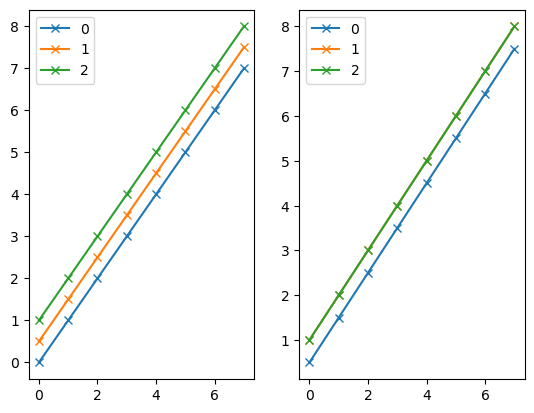

In [10]:
# ordered visual stimulation configuration (only works for one repetition)
static_moving_t_s = np.array([0.5, 0.5, 0])

nof_orient = 8

orient_angles_deg = np.arange(nof_orient) * (360/nof_orient)
orient_angles_rad = orient_angles_deg * (np.pi/180)
 
print(orient_angles_deg)

# conversion
nof_stim_steps = static_moving_t_s.size
tot_trail_t_s = np.sum(static_moving_t_s)

stim_tstamp_s = np.zeros((nof_orient, nof_stim_steps, 2))

cur_start_t_s = np.arange(nof_orient) * tot_trail_t_s
for i_step in range(nof_stim_steps):
    stim_tstamp_s[:, i_step, 0] = cur_start_t_s
    cur_start_t_s = cur_start_t_s + static_moving_t_s[i_step]
    stim_tstamp_s[:, i_step, 1] = cur_start_t_s

print(tot_trail_t_s)
print(stim_tstamp_s.shape)

plt.figure()
for i in range(2):
    plt.subplot(1,2,i + 1)
    for i_step in range(nof_stim_steps):
        plt.plot(stim_tstamp_s[:,i_step,i], "-x", label = f"{i_step}")
    plt.legend()
    
stim_tstamp = (stim_tstamp_s * s_to_ms)/time_per_frame_ms
stim_tstamp = stim_tstamp.astype(int)
    
SAVE_PROGRESS(HISTORY_FILEPATH)

In [79]:
# source configurations
# src_root_dir = r"M:\2023-05-11\M347\FOV02\Group01"
src_root_dir = r"M:\2023-05-11\M347\FOV02\Group04"

src_sub_dir_name = r"VolpyResults"
src_hdf5_file_name = r"results.hdf5"

dst_root_dir = src_root_dir
dst_dir_name = "StatsAnalysis"
dst_plot_sub_dir_name = "Plots"

t_test_alpha = 0.05
anova_test_alpha = 0.05

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysis_2023-07-22.py


In [80]:
# generate package name list 
src_pkg_names = listPkgNames(src_root_dir)
src_pkg_names = sortPkgNames(src_pkg_names)
print(src_pkg_names)

SAVE_PROGRESS(HISTORY_FILEPATH)

['Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F0_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F1_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F2_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F3_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F4_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F5_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F6_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F7_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F8_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F9_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F10_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F11_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F12_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F13_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F14_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F15_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F16_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F17_Pkg'
 'Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F18_Pkg'
 'Olympus25X_M347_FOV0

In [81]:
# load spike event information
NFRAMES_KEY = "roi0\\volpy_estimates\\dFF"
roi_regex = r"roi\d+"

fields = [
    "roi{iroi:d}\\stdThreshold\\spikes_invalid",
    "roi{iroi:d}\\stdThreshold\\spikes_valid",
    "roi{iroi:d}\\volpy_estimates\\spikes",
]

nof_fields = len(fields)
nof_roi = 0
nof_files = len(src_pkg_names)
nof_frames = 0

spike_events = None

#preprocess
for ipkg_name in [src_pkg_names[0]]:
    src_hdf5_file_path = os.path.join(src_root_dir, ipkg_name, src_sub_dir_name, src_hdf5_file_name)
    with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
        nof_frames = hdf5_file[NFRAMES_KEY].value.shape[0]
#         print(hdf5_file.keys()) # debug
        max_roi_num = 0
        for key in hdf5_file.keys():
            for istr in re.findall(roi_regex, key):
                cur_roi_num = int(istr[3:])
                max_roi_num = max(max_roi_num, cur_roi_num)
        nof_roi = max_roi_num + 1
        
spike_events = np.zeros((nof_roi, nof_fields, nof_files, nof_frames))

for ifile in range(nof_files):
    src_hdf5_file_path = os.path.join(src_root_dir, src_pkg_names[ifile], src_sub_dir_name, src_hdf5_file_name)
    print(src_hdf5_file_path)
    with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
        for iroi in range(nof_roi):
            for ifield in range(nof_fields):
                spike_idxs = hdf5_file[fields[ifield].format(iroi = iroi)].value
#                 print(spike_idxs)
                spike_events[iroi, ifield, ifile, spike_idxs] = 1

SAVE_PROGRESS(HISTORY_FILEPATH)

M:\2023-05-11\M347\FOV02\Group04\Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F0_Pkg\VolpyResults\results.hdf5
M:\2023-05-11\M347\FOV02\Group04\Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F1_Pkg\VolpyResults\results.hdf5


C:\Users\zhong\micromambaenv\envs\caiman\lib\site-packages\ipykernel_launcher.py:22: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
C:\Users\zhong\micromambaenv\envs\caiman\lib\site-packages\ipykernel_launcher.py:39: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


M:\2023-05-11\M347\FOV02\Group04\Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F2_Pkg\VolpyResults\results.hdf5
M:\2023-05-11\M347\FOV02\Group04\Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F3_Pkg\VolpyResults\results.hdf5
M:\2023-05-11\M347\FOV02\Group04\Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F4_Pkg\VolpyResults\results.hdf5
M:\2023-05-11\M347\FOV02\Group04\Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F5_Pkg\VolpyResults\results.hdf5
M:\2023-05-11\M347\FOV02\Group04\Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F6_Pkg\VolpyResults\results.hdf5
M:\2023-05-11\M347\FOV02\Group04\Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F7_Pkg\VolpyResults\results.hdf5
M:\2023-05-11\M347\FOV02\Group04\Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F8_Pkg\VolpyResults\results.hdf5
M:\2023-05-11\M347\FOV02\Group04\Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F9_Pkg\VolpyResults\results.hdf5
M:\2023-05-11\M347\FOV02\Group04\Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F10_Pkg\VolpyResults\results.hdf5
M:\2023-05-11\M347\FOV02\Group04\Oly

C:\Users\zhong\micromambaenv\envs\caiman\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == "__main__":
C:\Users\zhong\micromambaenv\envs\caiman\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\zhong\micromambaenv\envs\caiman\lib\site-pack

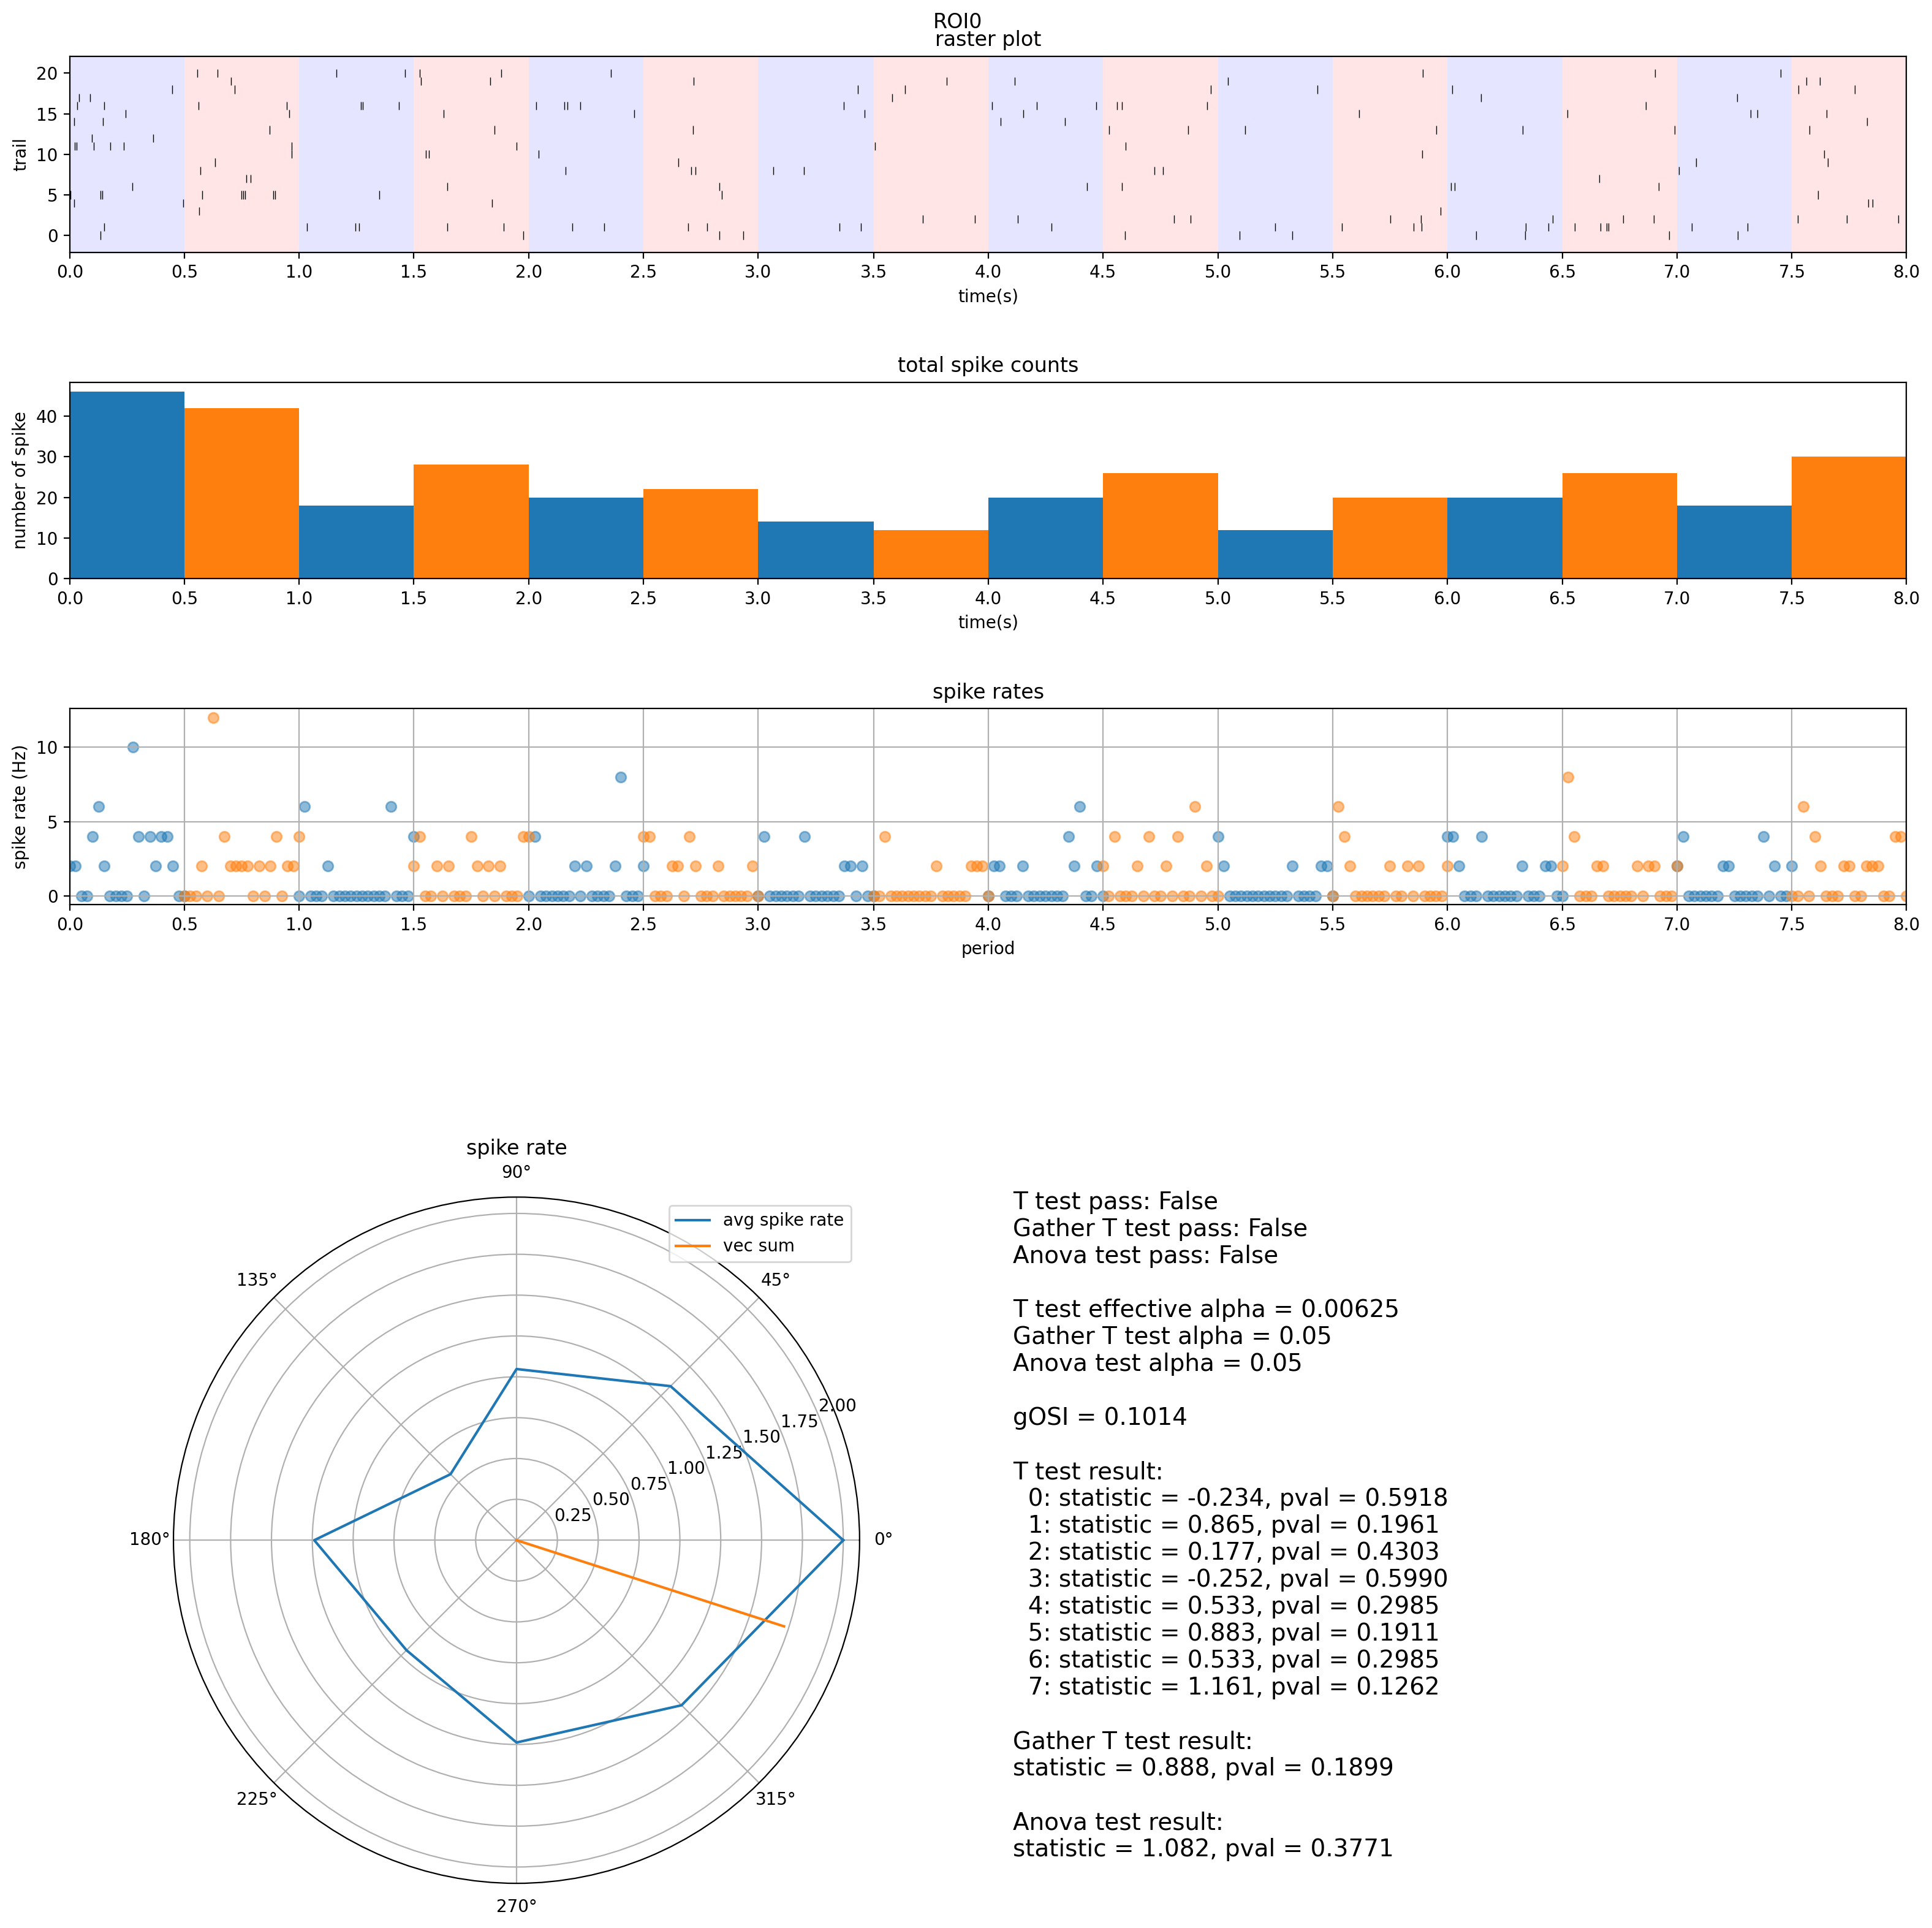

{'i_roi': 0, 'stim_tstamp': array([[[   0,  192],
        [ 192,  384],
        [ 384,  384]],

       [[ 384,  576],
        [ 576,  769],
        [ 769,  769]],

       [[ 769,  961],
        [ 961, 1153],
        [1153, 1153]],

       [[1153, 1346],
        [1346, 1538],
        [1538, 1538]],

       [[1538, 1730],
        [1730, 1923],
        [1923, 1923]],

       [[1923, 2115],
        [2115, 2307],
        [2307, 2307]],

       [[2307, 2500],
        [2500, 2692],
        [2692, 2692]],

       [[2692, 2884],
        [2884, 3076],
        [3076, 3076]]]), 'stim_tstamp_s': array([[[0. , 0.5],
        [0.5, 1. ],
        [1. , 1. ]],

       [[1. , 1.5],
        [1.5, 2. ],
        [2. , 2. ]],

       [[2. , 2.5],
        [2.5, 3. ],
        [3. , 3. ]],

       [[3. , 3.5],
        [3.5, 4. ],
        [4. , 4. ]],

       [[4. , 4.5],
        [4.5, 5. ],
        [5. , 5. ]],

       [[5. , 5.5],
        [5.5, 6. ],
        [6. , 6. ]],

       [[6. , 6.5],
        [6.5, 7. ]

In [82]:
preview_i_roi = 0
preview_i_field = 1 

spike_event = spike_events[preview_i_roi, preview_i_field, :, :]

result_summary = stats_analysis(
    preview_i_roi,
    spike_event,
    stim_tstamp,
    stim_tstamp_s,
    orient_angles_rad,
    t_test_alpha,
    anova_test_alpha,
    dst_dir_path = ".",
    process_mode = "show",
)

print(result_summary)

SAVE_PROGRESS(HISTORY_FILEPATH)

In [83]:
# batch processing
process_field = 1 

nof_roi = spike_events.shape[0]
nof_traces = spike_events.shape[2]
trace_len = spike_events.shape[3]
nof_orints = orient_angles_rad.shape[0]

dst_dir_path = os.path.join(dst_root_dir, dst_dir_name)
dst_plot_sub_dir_path = os.path.join(dst_dir_path, dst_plot_sub_dir_name)

if not os.path.isdir(dst_dir_path):
    os.makedirs(dst_dir_path)
    
if not os.path.isdir(dst_plot_sub_dir_path):
    os.makedirs(dst_plot_sub_dir_path)
    
result_summarys = []
for i_roi in range(nof_roi):
    
    spike_event = spike_events[i_roi, process_field, :, :]
    
    result_summary = stats_analysis(
        i_roi,
        spike_event,
        stim_tstamp,
        stim_tstamp_s,
        orient_angles_rad,
        t_test_alpha,
        anova_test_alpha,
        dst_dir_path = dst_plot_sub_dir_path,
        process_mode = "save",
    )
    
    result_summarys.append(result_summary)

SAVE_PROGRESS(HISTORY_FILEPATH)

C:\Users\zhong\micromambaenv\envs\caiman\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == "__main__":
C:\Users\zhong\micromambaenv\envs\caiman\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\zhong\micromambaenv\envs\caiman\lib\site-pack

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysis_2023-07-22.py


In [84]:
# save results to hdf5 file
dst_hdf5_file_name = "stats_analysis_data.hdf5"
dst_hdf5_file_path = os.path.join(dst_dir_path, dst_hdf5_file_name)

with h5py.File(dst_hdf5_file_path, "w") as hdf5_file:
    hdf5_file.create_dataset("time_per_frame_ms", data = time_per_frame_ms)
    hdf5_file.create_dataset("ms_to_s", data = ms_to_s)
    hdf5_file.create_dataset("s_to_ms", data = s_to_ms)
    hdf5_file.create_dataset("static_moving_t_s", data = static_moving_t_s)
    hdf5_file.create_dataset("nof_orient", data = nof_orient)
    hdf5_file.create_dataset("orient_angles_deg", data = orient_angles_deg)
    hdf5_file.create_dataset("orient_angles_rad", data = orient_angles_rad)
    hdf5_file.create_dataset("stim_tstamp_s", data = stim_tstamp_s)
    hdf5_file.create_dataset("stim_tstamp", data = stim_tstamp)
    hdf5_file.create_dataset("src_root_dir", data = src_root_dir)
    hdf5_file.create_dataset("src_sub_dir_name", data = src_sub_dir_name)
    hdf5_file.create_dataset("src_hdf5_file_name", data = src_hdf5_file_name)
    for i_str in range(len(src_pkg_names)):
        hdf5_file.create_dataset(f"src_pkg_names[{i_str}]", data = src_pkg_names.tolist()[i_str])
    hdf5_file.create_dataset("NFRAMES_KEY", data = NFRAMES_KEY)
    for i_str in range(len(fields)):
        hdf5_file.create_dataset(f"fields[{i_str}]", data = fields[i_str])
    hdf5_file.create_dataset("nof_fields", data = nof_fields)
    hdf5_file.create_dataset("nof_roi", data = nof_roi)
    hdf5_file.create_dataset("nof_files", data = nof_files)
    hdf5_file.create_dataset("nof_frames", data = nof_frames)
    hdf5_file.create_dataset("spike_events", data = spike_events)
    hdf5_file.create_dataset("process_field", data = process_field)
    
    stats_result_tage = "stats_result"
    for i_roi in range(nof_roi):
        cur_result = result_summarys[i_roi]
        roi_num = cur_result["i_roi"]
        roi_name = f"roi{roi_num}"
        dirct_save_keys = [
            "cur_spike_event",
            "cur_spike_cnts",
            "cur_spike_rate",
            "t_test_pvals",
            "t_test_effective_alpha",
            "t_test_alpha",
            "anova_test_alpha",
            "t_test_pass",
            "gather_t_test_pass",
            "annova_test_pass",
            "responses",
            "gOSI",
        ]
        for key in dirct_save_keys:
            hdf5_save_key = os.path.join(roi_name, key)
            hdf5_file.create_dataset(hdf5_save_key, data = cur_result[key])
        
        vec_sum_hdf5_save_key = os.path.join(roi_name, "vec_sum_complex")
        hdf5_file.create_dataset(vec_sum_hdf5_save_key, data = cur_result["vec_sum_complex"])
        hdf5_file.create_dataset(vec_sum_hdf5_save_key + ".amp", 
                                 data = np.abs(cur_result["vec_sum_complex"]))
        hdf5_file.create_dataset(vec_sum_hdf5_save_key + ".ang", 
                                 data = np.angle(cur_result["vec_sum_complex"]))

        gather_t_test_result_hdf5_save_key = os.path.join(roi_name, "gather_t_test_result")
        hdf5_file.create_dataset(gather_t_test_result_hdf5_save_key + ".statistic", 
                                 data = cur_result["gather_t_test_result"].statistic)
        hdf5_file.create_dataset(gather_t_test_result_hdf5_save_key +".pvalue",
                                data = cur_result["gather_t_test_result"].pvalue)
        
        anova_test_result_hdf5_save_key = os.path.join(roi_name, "anova_test_result")
        hdf5_file.create_dataset(anova_test_result_hdf5_save_key + ".statistic", 
                                 data = cur_result["anova_test_result"].statistic)
        hdf5_file.create_dataset(anova_test_result_hdf5_save_key +".pvalue",
                                data = cur_result["anova_test_result"].pvalue)
        
        t_test_results_hdf5_save_key = os.path.join(roi_name, "t_test_results")
        for i_test_res in range(len(cur_result["t_test_results"])):
            hdf5_file.create_dataset(t_test_results_hdf5_save_key + f"[{i_test_res}].statistic",
                                    data = cur_result["t_test_results"][i_test_res].statistic)
            hdf5_file.create_dataset(t_test_results_hdf5_save_key + f"[{i_test_res}].pvalue",
                                    data = cur_result["t_test_results"][i_test_res].pvalue)
SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysis_2023-07-22.py


In [85]:
for ifile in range(1):
    src_hdf5_file_path = os.path.join(src_root_dir, src_pkg_names[ifile], src_sub_dir_name, src_hdf5_file_name)
    print(src_hdf5_file_path)
    with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
        print(hdf5_file.keys())

M:\2023-05-11\M347\FOV02\Group04\Olympus25X_M347_FOV02_Group04_TS_CH0_CHA_F0_Pkg\VolpyResults\results.hdf5
<KeysViewHDF5 ['roi0\\stdThreshold\\spikes_invalid', 'roi0\\stdThreshold\\spikes_valid', 'roi0\\volpy_estimates\\F0', 'roi0\\volpy_estimates\\cell_n', 'roi0\\volpy_estimates\\context_coord', 'roi0\\volpy_estimates\\dFF', 'roi0\\volpy_estimates\\locality', 'roi0\\volpy_estimates\\low_spikes', 'roi0\\volpy_estimates\\mean_im', 'roi0\\volpy_estimates\\num_spikes', 'roi0\\volpy_estimates\\rawROI\\dFF', 'roi0\\volpy_estimates\\rawROI\\spikes', 'roi0\\volpy_estimates\\rawROI\\t', 'roi0\\volpy_estimates\\rawROI\\templates', 'roi0\\volpy_estimates\\rawROI\\ts', 'roi0\\volpy_estimates\\rawROI\\weights', 'roi0\\volpy_estimates\\snr', 'roi0\\volpy_estimates\\spikes', 'roi0\\volpy_estimates\\t', 'roi0\\volpy_estimates\\t_rec', 'roi0\\volpy_estimates\\t_sub', 'roi0\\volpy_estimates\\templates', 'roi0\\volpy_estimates\\thresh', 'roi0\\volpy_estimates\\ts', 'roi0\\volpy_estimates\\weights', 'roi

In [86]:
with h5py.File(dst_hdf5_file_path, "r") as hdf5_file:
    print(hdf5_file.keys())

<KeysViewHDF5 ['NFRAMES_KEY', 'fields[0]', 'fields[1]', 'fields[2]', 'ms_to_s', 'nof_fields', 'nof_files', 'nof_frames', 'nof_orient', 'nof_roi', 'orient_angles_deg', 'orient_angles_rad', 'process_field', 'roi0\\annova_test_pass', 'roi0\\anova_test_alpha', 'roi0\\anova_test_result.pvalue', 'roi0\\anova_test_result.statistic', 'roi0\\cur_spike_cnts', 'roi0\\cur_spike_event', 'roi0\\cur_spike_rate', 'roi0\\gOSI', 'roi0\\gather_t_test_pass', 'roi0\\gather_t_test_result.pvalue', 'roi0\\gather_t_test_result.statistic', 'roi0\\responses', 'roi0\\t_test_alpha', 'roi0\\t_test_effective_alpha', 'roi0\\t_test_pass', 'roi0\\t_test_pvals', 'roi0\\t_test_results[0].pvalue', 'roi0\\t_test_results[0].statistic', 'roi0\\t_test_results[1].pvalue', 'roi0\\t_test_results[1].statistic', 'roi0\\t_test_results[2].pvalue', 'roi0\\t_test_results[2].statistic', 'roi0\\t_test_results[3].pvalue', 'roi0\\t_test_results[3].statistic', 'roi0\\t_test_results[4].pvalue', 'roi0\\t_test_results[4].statistic', 'roi0\\t_